# Visualizing filters in Pytorch

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
import torch
import numpy as np

/home/olros/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Image shape: (224, 224)


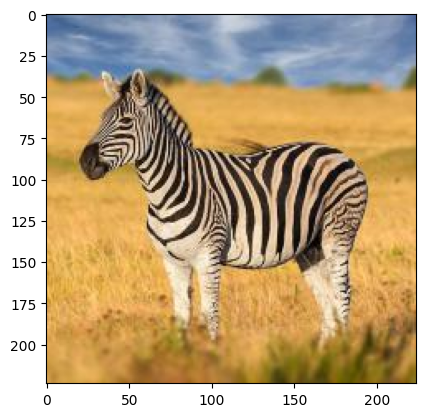

In [2]:
image = Image.open("images/zebra.jpg")
plt.imshow(image)
print("Image shape:", image.size)

### Model definition

In [3]:
# In this example we will use a pre-trained ResNet50 network.
# ResNet-50 is a fully-convolutional neural network that excels at image classification.
model = torchvision.models.resnet50(pretrained=True)
print(model)

/home/olros/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/olros/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/olros/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:06<00:00, 16.9MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### First convolution layer

In [4]:
# In this task we are interested in visualizing the first convolutional layer. This can be retrieved by the following code block: 
first_conv_layer = model.conv1
print("First conv layer weight shape:", first_conv_layer.weight.shape)
print("First conv layer:", first_conv_layer)
# Observe that it has 64 filters/kernels in the layer. Each kernel is a $7 \times 7$ filter, that takes an RGB image as input

First conv layer weight shape: torch.Size([64, 3, 7, 7])
First conv layer: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


### Activation from first layer

In [5]:
# We need to resize, and normalize the image with the mean and standard deviation that they used to originally train this network.
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [6]:
# Apply the image transform to the zebra image
image = image_transform(image)[None]
print("Image shape:", image.shape)
# By running the image through the first layer, we get an activation.
# We can retrieve the activation from the first layer by doing a forward pass throught this conv layer.
activation = first_conv_layer(image)
print("Activation shape:", activation.shape)

Image shape: torch.Size([1, 3, 224, 224])
Activation shape: torch.Size([1, 64, 112, 112])


In [7]:
# Also, we can retrieve the weight from the first convolution layer with the following:
weight = model.conv1.weight.data.cpu()
print("Filter/Weight/kernel size:", weight.shape)

Filter/Weight/kernel size: torch.Size([64, 3, 7, 7])


### Visualize filters & Activation

In [8]:
def torch_image_to_numpy(image: torch.Tensor):
    """
        We've created a function `torch_image_to_numpy` to help you out.
        This function transforms an torch tensor with shape (batch size, num channels, height, width) to
        (batch size, height, width, num channels) numpy array
    """
    # Normalize to [0 - 1.0]
    image = image.detach().cpu() # Transform image to CPU memory (if on GPU VRAM)
    image = image - image.min()
    image = image / image.max()
    image = image.numpy()
    if len(image.shape) == 2: # Grayscale image, can just return
        return image
    assert image.shape[0] == 3, "Expected color channel to be on first axis. Got: {}".format(image.shape)
    image = np.moveaxis(image, 0, 2)
    return image

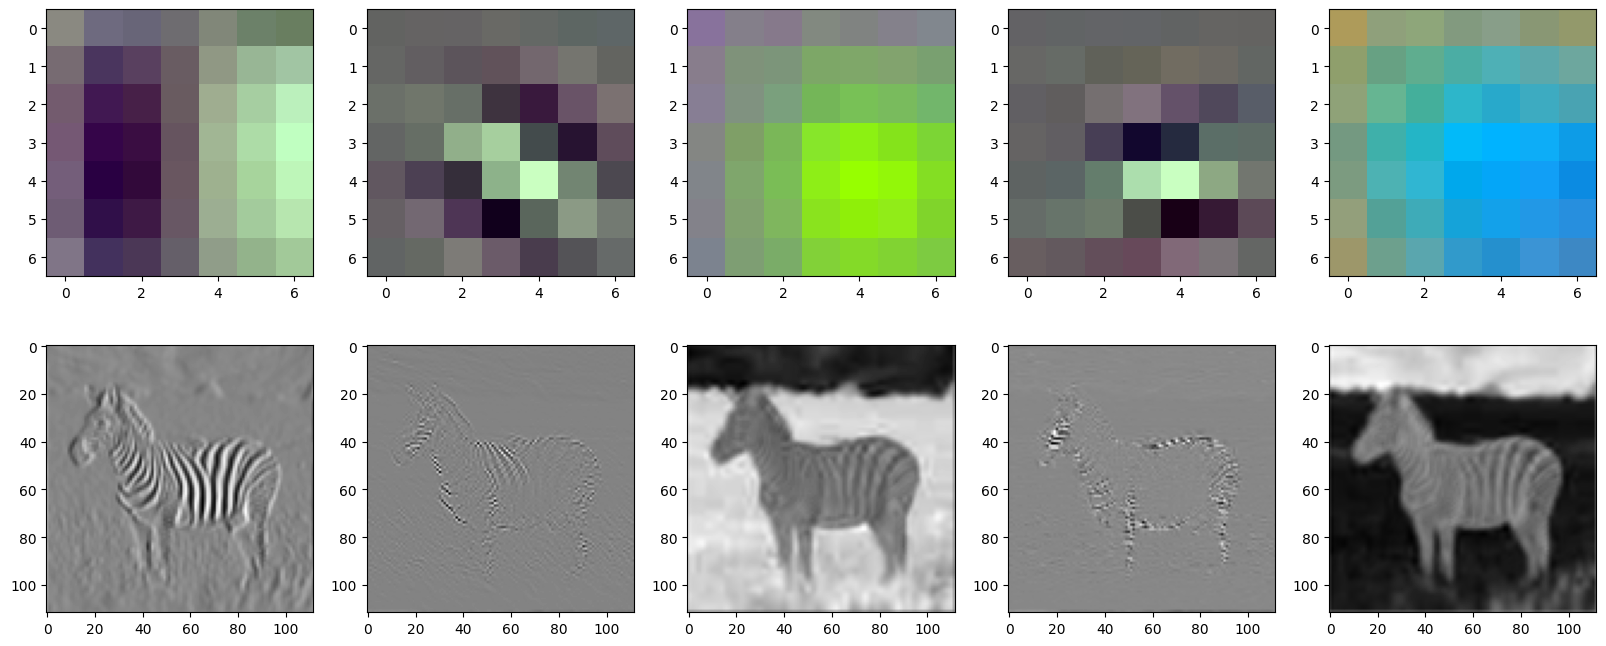

In [21]:
import utils

indices = [5, 8, 19, 22, 34]
num_filters = len(indices)

plt.figure(figsize=(20, 8))

n = 1
for i in indices:
    plt.subplot(2, num_filters, n)
    # Plot weight here
    plt.imshow(torch_image_to_numpy(weight[i]))

    plt.subplot(2, num_filters, num_filters+n)
    # Plot activation here
    plt.imshow(torch_image_to_numpy(activation[0][i]), cmap='gray')
    n += 1

plt.savefig(utils.image_output_dir.joinpath("task2c.png"))